# Exercise 8: Stochastic Optimization

Machine Intelligence 2
SS 2017, Obermayer/Augustin/Guo
due: 2017-06-14
Group: Outlaws

Used Python version 3.5.2 (https://www.continuum.io/downloads, http://ipython.org/install.html)


In [1]:
import sys
print(sys.version)

3.6.0 |Anaconda 4.3.1 (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
def showPlot(title, costs, betas, M=None):
    fig, ax = plt.subplots(nrows=2, figsize=(13, 7))
    ax[0].set_title('{} Energy'.format(title))
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('E(s)')
    ax[1].set_title('Temperature')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel(r'$\beta^{-1}$')
    if M is None:
        ax[0].plot(np.arange(len(costs)), costs)
    else:
        for midx in range(len(M)):
            ax[0].plot(np.arange(len(costs[midx])), costs[midx], label="M = {}".format(M[midx]))

    
    temps = [1 / x for x in betas]
    ax[1].step(np.arange(len(temps)), temps)

    ax[0].legend()
    fig.tight_layout()
    plt.show()       

## Annealing Methods for Optimization

In [4]:
seed = 127
random = np.random.RandomState(seed)

def get_ramdom_weights(n=6):
    random = np.random.RandomState(seed)
    w = random.rand(n, n) * 2-1
    
    w = (w + w.T)/2
   
    w *= (1 - np.eye(n))
    return w

def update(states, weights, beta, M=1):
    for _ in range(M):
        node = random.randint(0, states.shape[0])
        delta_energy = -2 * local_energy(states, weights, node)
        probability=0
        probability = getProbability(delta_energy, beta)
        if random.rand() < probability:
            states[node] *= -1
    return states
    

def getProbability(delta_energy, beta):
    return 1 / (1 + np.e ** (beta * delta_energy))

def energy(state, weight):
    return -0.5 * (np.outer(state, state) * weight).sum()

def local_energy(state, weight, node):
    return -0.5 * (state[node] * state * weight[node]).sum()

initial state: [ 1 -1 -1 -1 -1  1]
M is   1,
cost: -2.868,
states result [-1  1 -1  1 -1 -1]
M is 500,
cost: -2.868,
states result [-1  1 -1  1 -1 -1]


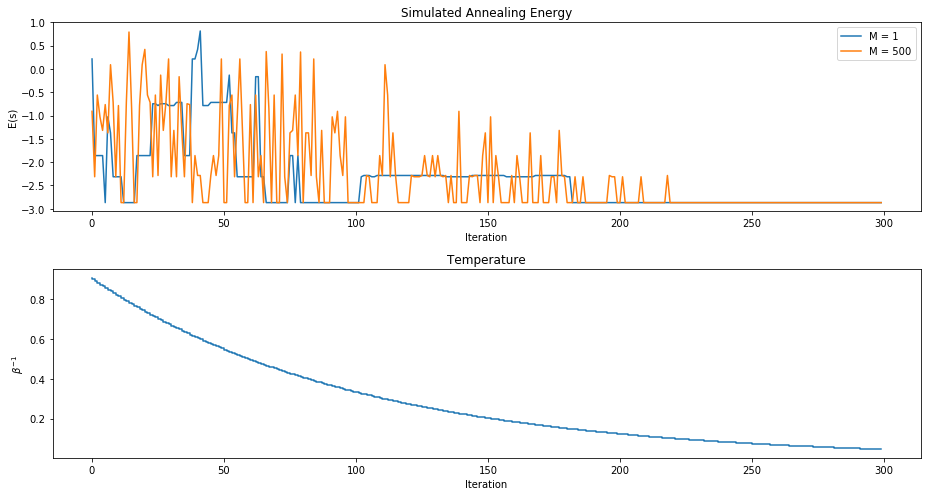

In [5]:


N = 6
tmax=300
beta=1.01
tau=1.01
M=(1,500)
#initial state
states = np.array([-1, 1])[random.randint(0, 2, N)]
print("initial state: {}".format(states))
weights = get_ramdom_weights(N)
costs = np.zeros((len(M),tmax))

for Midx in range(len(M)):
    beta=1.1
    betas = []
    for t in range(tmax):
        states = update(states, weights, beta,M[Midx])
        costs[Midx][t]= energy(states, weights)
        betas.append(beta)
        beta *= tau

    print('M is {:>3},\ncost: {:5.3f},\nstates result {}'.format(M[Midx], 
                                                       costs[Midx][-1], states))


showPlot('Simulated Annealing',costs, betas, M)




## Show the energy E(s) for all possible states using a bar plot.

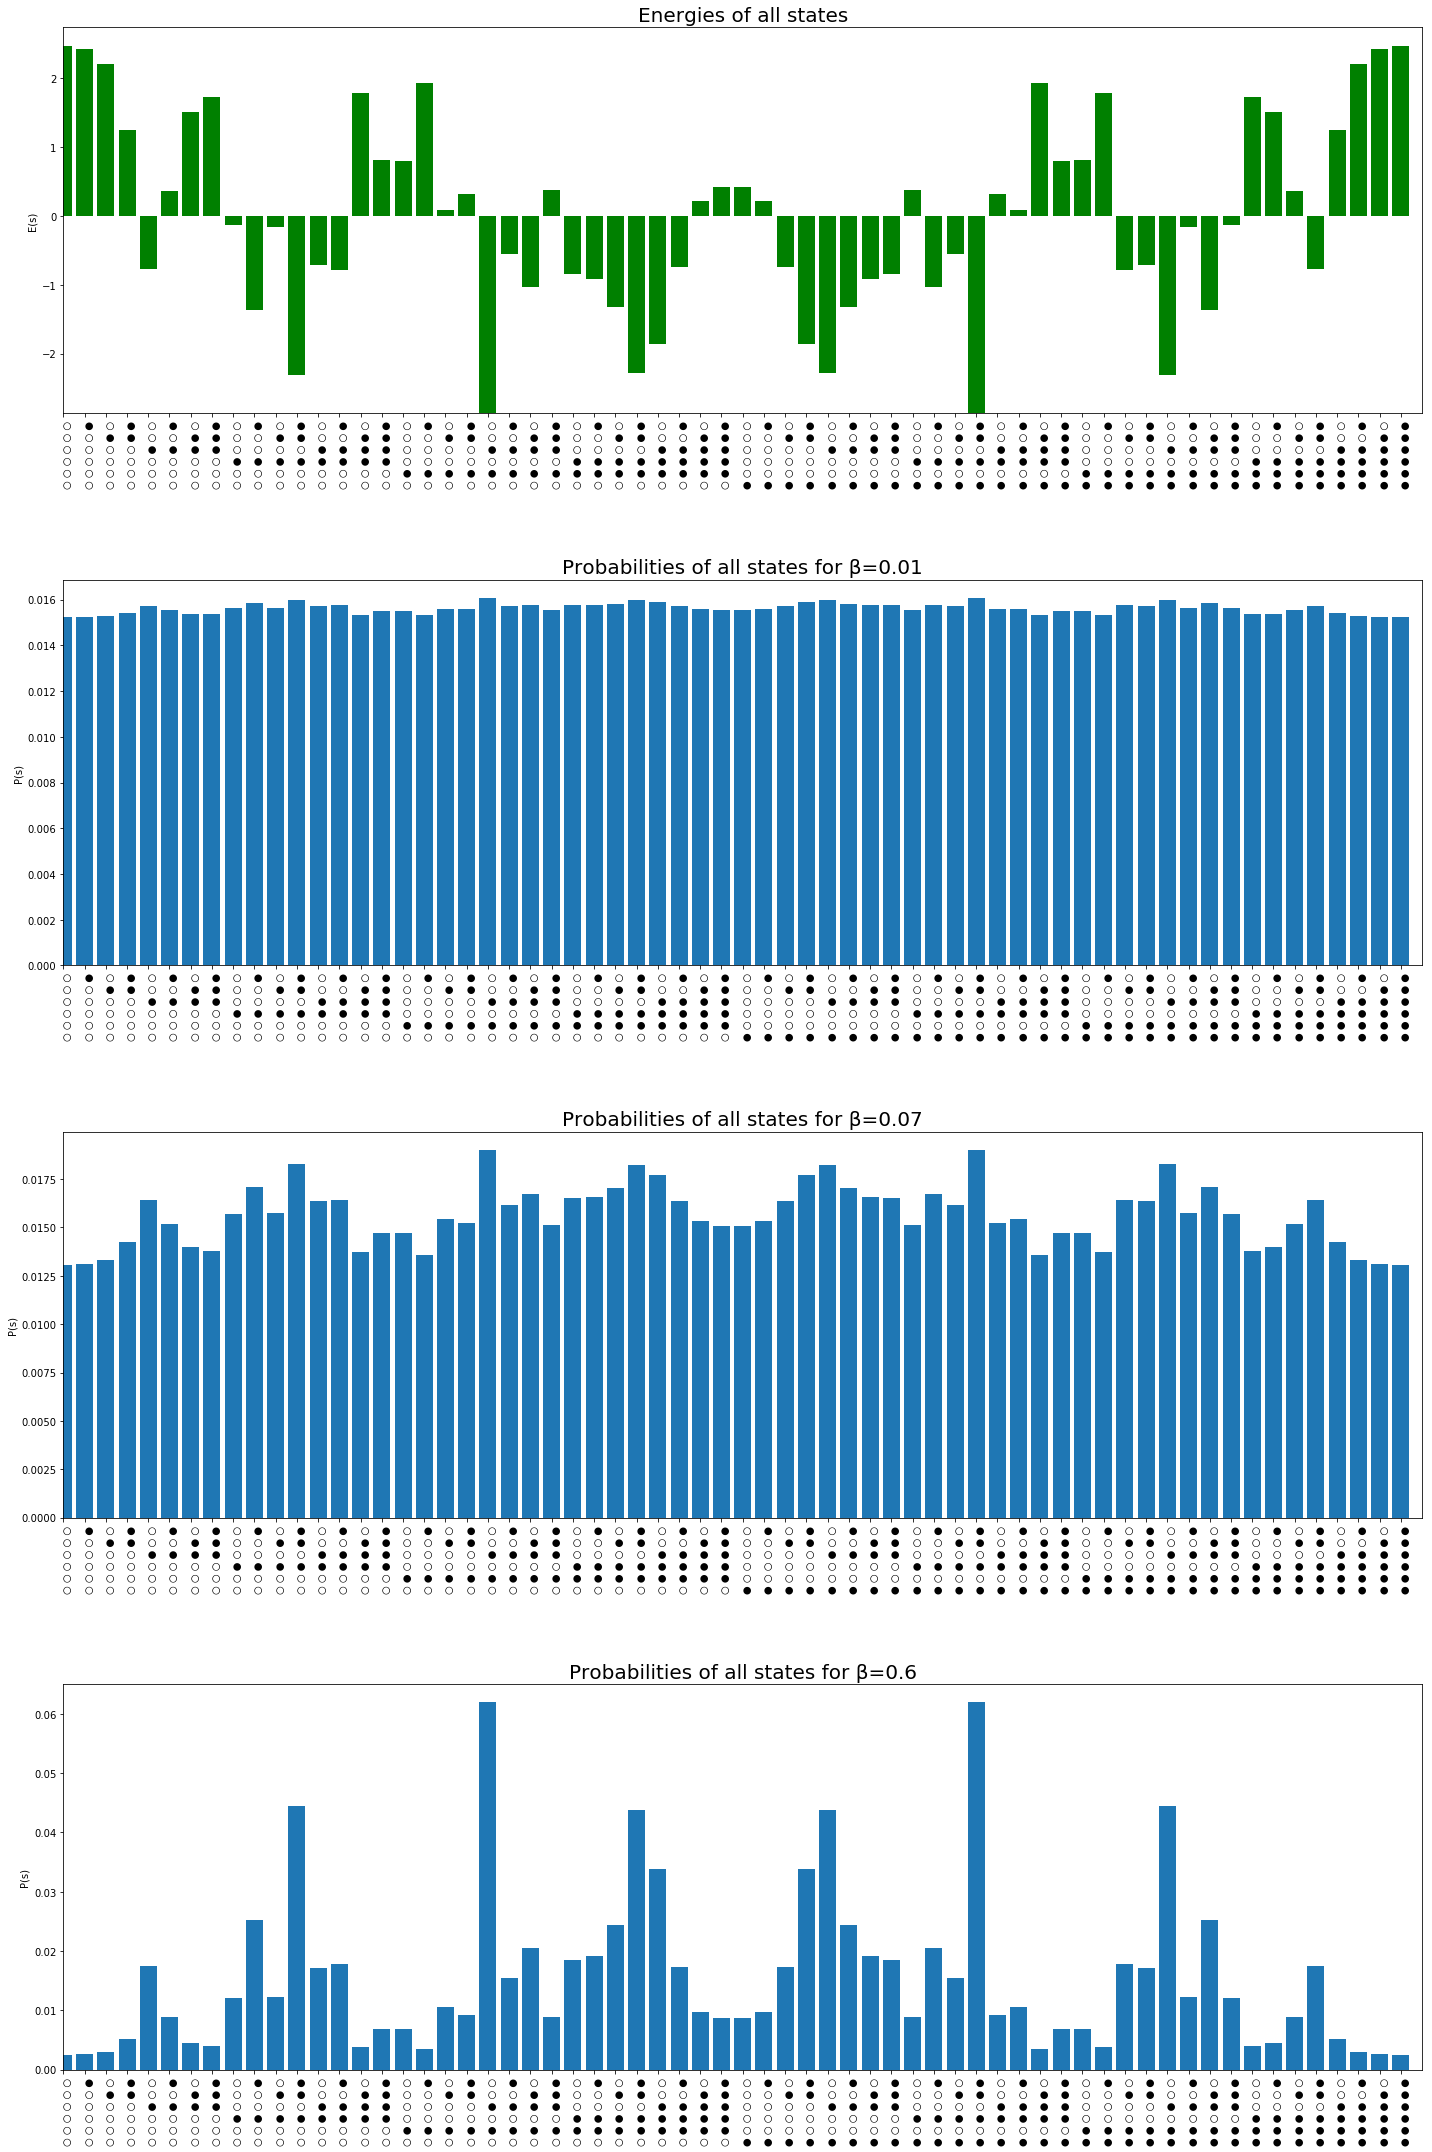

In [6]:
import collections
import glob
import itertools

N = 6
betas = [0.01, 0.07, 0.6]  

weights = get_ramdom_weights(N)

allPStates = itertools.product([-1,1], repeat=N)
allPStates = np.array(list(allPStates))

labels = [' '.join(['', '●', '○'][y] for y in x) for x in allPStates]

n = allPStates.shape[0]

energies = np.zeros(n)
probabilities = np.zeros(n)


for i, state in enumerate(allPStates):
    energies[i] = energy(state, weights)
    
def probabilities(beta):
    probabilities = np.zeros(n)
    for i, states in enumerate(allPStates):
        probabilities[i] = np.exp(-(beta * energy(states,weights)))
        z = np.sum(np.exp(energies*beta))
    return probabilities/z


fig, ax = plt.subplots(4, 1, figsize=(20, 30))

for axis in ax:
    axis.set_xlim([0,64])
    axis.set_xticks(np.arange(64))
    axis.set_xticklabels(labels, rotation='vertical', ha='left');

ax[0].bar(np.arange(n), energies, color='green')
ax[0].set_ylabel('E(s)')
ax[0].set_title('Energies of all states', fontsize=20)

ax[1].bar(np.arange(n), probabilities(betas[0]))
ax[1].set_ylabel('P(s)')
ax[1].set_title('Probabilities of all states for β='+str(betas[0]), fontsize=20)

ax[2].bar(np.arange(n), probabilities(betas[1]))
ax[2].set_ylabel('P(s)')
ax[2].set_title('Probabilities of all states for β='+str(betas[1]), fontsize=20)

ax[3].bar(np.arange(n), probabilities(betas[2]))
ax[3].set_ylabel('P(s)')
ax[3].set_title('Probabilities of all states for β='+str(betas[2]), fontsize=20)

fig.tight_layout(h_pad=7.0)

## Mean Field Annealing

- Deterministic approximation of simulated annealing
- A possible strategy might seem to evaluate P(s) (Gibbs-distribution)
    - But obtaining maxima of P(s) is as hard as obtaining minima of E
    - And also moments of P(s) cannot be calculated analytically (in general)
- A feasable strategy is to approximate P(s) by Q(s)

$ Q_(s) = \frac{1}{Z_Q}\exp(-ß E_Q) = \frac{1}{Z_Q}\exp(-ß \sum_{k} e_k s_k) $

$ e_i = - \sum_{j \in N_i} w_{ij} s_j$

Goal: determine e such that approximation is good as possible

initial state: [ 0.00476666 -0.09200741 -0.06280694  0.05455813  0.01042978 -0.08274462]
cost: -2.867,
states result [-0.99987412  1.         -0.99999995  1.         -1.         -1.        ]


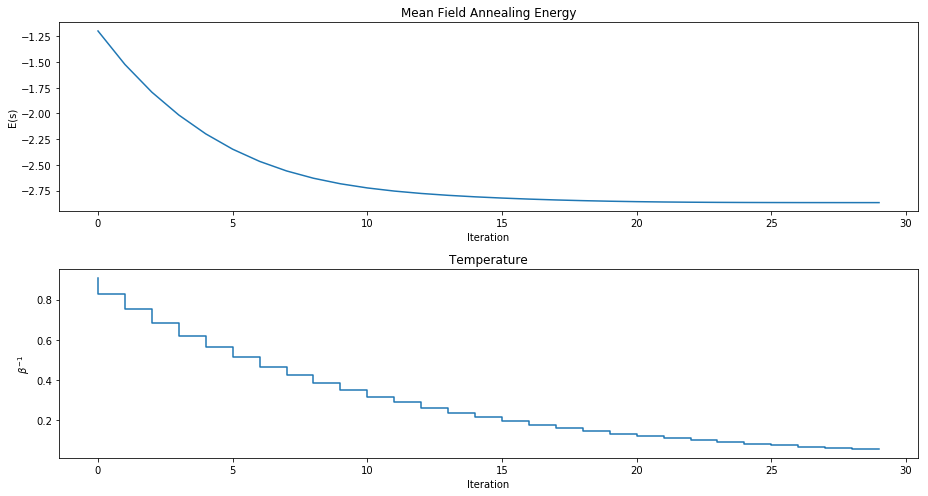

In [7]:
#Pick epsilon small enough
epsilon=1e-3

#Pick beta again small enough and tau bigger than 1
N = 6
tmax=30
beta=1.1
tau=1.1

betas = []

def mf_update(states, weights, beta):
    history = collections.deque(maxlen=2)
    while not convergence(history):
       
        mean_field_e = np.zeros(len(states))
        for i in range(len(states)):
            for j in range(len(states)):
                if i!=j:
                    mean_field_e[i] += weights[i][j] * states[j]
            mean_field_e[i] *= -1.0
        
        states = np.tanh(-beta * mean_field_e)
        history.append(mean_field_e)
    return states

def convergence(history):
    if len(history) < 2:
        return False
    change = history[1] - history[0]
    return (np.absolute(change) < epsilon).all()



#initial state
states = 0.1 * (np.random.RandomState(seed).rand(N) * 2 - 1)
print("initial state: {}".format(states))

weights = get_ramdom_weights(N)
costs = np.zeros(tmax)


for t in range(tmax):
    states = mf_update(states, weights, beta)
    costs[t]= energy(states, weights)
    betas.append(beta)
    beta *= tau

print('cost: {:5.3f},\nstates result {}'.format(costs[-1], states))

showPlot('Mean Field Annealing',costs, betas)